# Invoice OCR & Structured Data Extraction Workflow

## Workflow Summary

1. **Image Enhancement**
   - The process begins by enhancing the invoice image using **Google Nano Banana** to improve text clarity and OCR accuracy.

2. **Preprocessing**
   - The enhanced image is preprocessed with **OpenCV**:
     - Resizing
     - Denoising
     - Adaptive thresholding
   - The preprocessed image is then passed to **EasyOCR** to extract Arabic and English text.

3. **Text Normalization**
   - Raw OCR output is normalized by:
     - Standardizing digits and number formats
     - Correcting punctuation
   - This reduces noise and ambiguity in the extracted text.

4. **LLM Extraction**
   - The cleaned text is combined with a predefined invoice schema.
   - Sent to **Qwen 2.5 Instruct LLM**, which is strictly prompted to:
     - Extract only explicitly present information
     - Return valid JSON with fixed keys

5. **Validation & Export**
   - Structured JSON output is validated.
   - Exported into **CSV files** for downstream use:
     - Invoice metadata
     - Line items
     - Financial summary

The results in the end isn't perfect but this is POC to prove I can achieve the project correctly


In [1]:
# Installing the main requirements
!pip install --quiet easyocr opencv-python-headless pandas matplotlib
!pip uninstall -y transformers transformers_stream_generator
!pip install -q transformers==4.37.2
!pip install -q transformers_stream_generator==0.0.4
!pip install -q accelerate sentencepiece torch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [18]:
# Importing the main requirements
import sys
import re
import io
import os
from typing import List, Dict, Tuple, Any
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import easyocr

In [19]:
# Don't forget to put the enhanced Image in the Files
# Just send the image to Gemini, it will be ehanced, later on we will use other methdologies.
image_path = "/content/invoice.png"
print("Loaded file:", image_path)

Loaded file: /content/invoice.png
Loaded file: /content/invoice.png


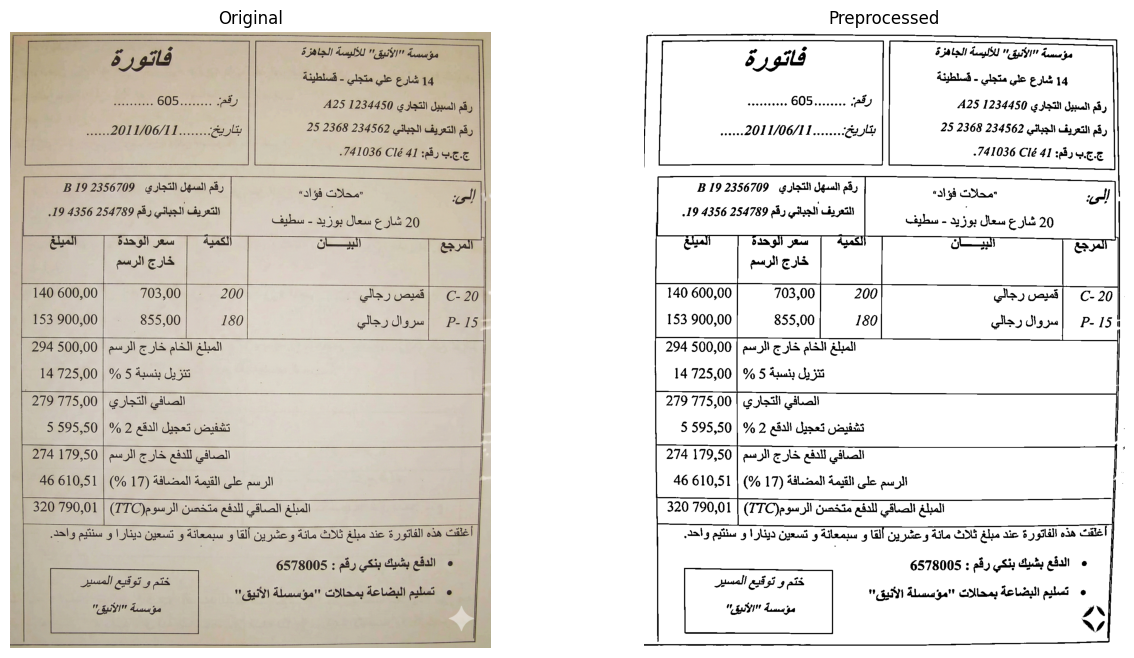

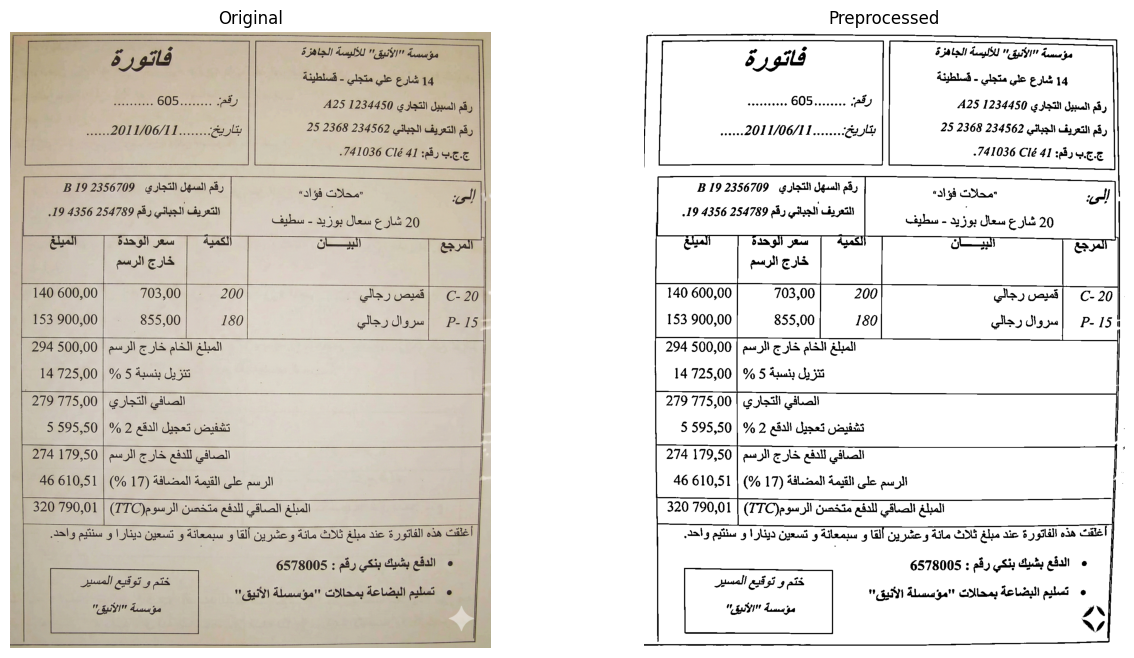

In [20]:
def show_images_side_by_side(img_list, titles=None, figsize=(15, 8)):
    n = len(img_list)
    plt.figure(figsize=figsize)
    for i, img in enumerate(img_list):
        plt.subplot(1, n, i+1)
        if len(img.shape) == 3:
            img_to_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_to_show)
        else:
            plt.imshow(img, cmap='gray')
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

def preprocess_image(path: str, resize_max: int = 1600) -> Tuple[np.ndarray, np.ndarray]:
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR) \
          if os.name == 'nt' else cv2.imread(path)
    if img is None:
        with open(path, "rb") as f:
            arr = np.frombuffer(f.read(), np.uint8)
            img = cv2.imdecode(arr, cv2.IMREAD_COLOR)

    h, w = img.shape[:2]
    if max(h, w) > resize_max:
        scale = resize_max / max(h, w)
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 31, 2)
    return img, thresh

original_img, preprocessed_img = preprocess_image(image_path)
show_images_side_by_side([original_img, preprocessed_img], titles=["Original", "Preprocessed"])


In [21]:
# Initializing the arabic and english
reader = easyocr.Reader(['ar', 'en'], gpu=True)

ocr_results = reader.readtext(preprocessed_img, detail=1, paragraph=False)

# ocr_results is list of tuples: (bbox, text, confidence)
raw_lines = [t[1].strip() for t in ocr_results if t[1].strip()]

for bbox, text, conf in ocr_results:
    print(f"{text}  | confidence: {conf:.2f}")

raw_text = "\n".join(raw_lines)

فاتورة  | confidence: 0.99
مؤسسة " الأنيق " للأليسة الجاهزة  | confidence: 0.59
14 شارع علي متجلي - فسلطينة  | confidence: 0.70
605.  | confidence: 0.70
رقم ,  | confidence: 0.41
A25 1234450 رقم السبيل التجاري  | confidence: 0.64
بتاريخ ........2011/06/11  | confidence: 0.78
رقم التعريف الجباني 234562 2368 25  | confidence: 0.68
741036 Cl& 41  | confidence: 0.51
ج .ج  ب رقم :  | confidence: 0.25
8 19 2356709  | confidence: 0.73
رقم السهل  | confidence: 0.88
"محلات فواد "  | confidence: 0.49
التعريف الجبانى رقم 254789 4356 19.  | confidence: 0.67
سطيف  | confidence: 0.98
سعال بوزيد  | confidence: 0.88
20  | confidence: 1.00
آلوحدة  | confidence: 0.89
لعل  | confidence: 0.39
آلكمية  | confidence: 0.35
لبي  | confidence: 0.93
المرجع  | confidence: 0.57
خارج  | confidence: 1.00
140 600,00  | confidence: 0.94
703,00  | confidence: 0.94
200  | confidence: 1.00
رجالي  | confidence: 0.52
C- 20  | confidence: 0.65
153 900,00  | confidence: 0.97
855,00  | confidence: 0.99
180  | confidence: 0.71

In [22]:
# Normalization utilities
# The main purpose here is to clean the dataset a little bit to enhance it to work with it in the LLM
ARABIC_DIGITS = {'٠': '0', '١': '1', '٢': '2', '٣': '3', '٤': '4', '٥': '5', '٦': '6', '٧': '7', '٨': '8', '٩': '9'}

def normalize_digits(s: str) -> str:
    for ar, en in ARABIC_DIGITS.items():
        s = s.replace(ar, en)
    return s

def normalize_punctuation(s: str) -> str:
    s = s.replace('،', ',').replace('٫', '.').replace('٬', ',')
    return s

def clean_whitespace(s: str) -> str:
    s = re.sub(r'\u200f', '', s)
    s = re.sub(r'[ \t]+', ' ', s)
    s = re.sub(r'\n{2,}', '\n', s)
    return s.strip()

def normalize_numbers(s: str) -> str:
    # Convert arabic digits, normalize commas/dots to unified decimal separator,
    s = normalize_digits(s)
    s = normalize_punctuation(s)
    s = re.sub(r'(?<=\d)[,](?=\d{3}\b)', '', s)
    s = re.sub(r'(?<=\d)[.](?=\d{3}\b)', '', s)
    return s

def normalize_line(s: str) -> str:
    s = s.strip()
    s = normalize_digits(s)
    s = normalize_punctuation(s)
    s = normalize_numbers(s)
    s = clean_whitespace(s)
    return s

normalized_lines = [normalize_line(l) for l in raw_lines if l.strip()]
normalized_text = "\n".join(normalized_lines)

In [23]:
# Define expected schema

INVOICE_SCHEMA = {
    "invoice_metadata": {
        "invoice_number": "",
        "invoice_date": "",
        "seller_name": "",
        "buyer_name": "",
        "commercial_registration_number": "",
        "address": ""
    },
    "line_items": [
        {
            "description": "",
            "quantity": "",
            "unit_price": "",
            "total_price": ""
        }
    ],
    "financial_summary": {
        "subtotal": "",
        "vat_percentage": "",
        "vat_amount": "",
        "final_total": ""
    }
}

In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

In [9]:
# Here we are using Qwen 1.5B but we can use a better model but this one is used to proof the concept.
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16
)

# Force to use the GPU for faster inference.
assert torch.cuda.is_available(), "CUDA is not available!"
model = model.to("cuda")
model.eval()

print("Model loaded on:", next(model.parameters()).device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model loaded on: cuda:0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
# Here we are Setting up the system prompt and user prompt
import json

SYSTEM_PROMPT = """
You are a strict information extraction engine.
You extract structured data from OCR text.

Rules:
- Use ONLY the provided OCR text
- Fill values ONLY if explicitly present
- Do NOT guess
- Do NOT change schema keys
- Return VALID JSON ONLY
- Empty string "" if value not found
"""

USER_PROMPT = f"""
Extract invoice information and fill the schema below.

SCHEMA:
{json.dumps(INVOICE_SCHEMA, ensure_ascii=False, indent=2)}

OCR TEXT:
{normalized_text}

Return ONLY JSON.
"""

In [11]:
# Sending the Prompt to the LLM
messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": USER_PROMPT}
]

prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

In [12]:
# Debugging
print("===== PROMPT SENT TO LLM =====")
print(prompt[:5000])   # first 5k Char

===== PROMPT SENT TO LLM =====
<|im_start|>system

You are a strict information extraction engine.
You extract structured data from OCR text.

Rules:
- Use ONLY the provided OCR text
- Fill values ONLY if explicitly present
- Do NOT guess
- Do NOT change schema keys
- Return VALID JSON ONLY
- Empty string "" if value not found
<|im_end|>
<|im_start|>user

Extract invoice information and fill the schema below.

SCHEMA:
{
  "invoice_metadata": {
    "invoice_number": "",
    "invoice_date": "",
    "seller_name": "",
    "buyer_name": "",
    "commercial_registration_number": "",
    "address": ""
  },
  "line_items": [
    {
      "description": "",
      "quantity": "",
      "unit_price": "",
      "total_price": ""
    }
  ],
  "financial_summary": {
    "subtotal": "",
    "vat_percentage": "",
    "vat_amount": "",
    "final_total": ""
  }
}

OCR TEXT:
فاتورة
مؤسسة " الأنيق " للأليسة الجاهزة
14 شارع علي متجلي - فسلطينة
605.
رقم ,
A25 1234450 رقم السبيل التجاري
بتاريخ ........2011/

In [13]:
# Generating the prompt from the QWEN
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=1200,
        temperature=0.0,
        do_sample=False
    )

llm_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("===== RAW LLM OUTPUT =====")
print(llm_output)

/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:407: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


===== RAW LLM OUTPUT =====
system

You are a strict information extraction engine.
You extract structured data from OCR text.

Rules:
- Use ONLY the provided OCR text
- Fill values ONLY if explicitly present
- Do NOT guess
- Do NOT change schema keys
- Return VALID JSON ONLY
- Empty string "" if value not found

user

Extract invoice information and fill the schema below.

SCHEMA:
{
  "invoice_metadata": {
    "invoice_number": "",
    "invoice_date": "",
    "seller_name": "",
    "buyer_name": "",
    "commercial_registration_number": "",
    "address": ""
  },
  "line_items": [
    {
      "description": "",
      "quantity": "",
      "unit_price": "",
      "total_price": ""
    }
  ],
  "financial_summary": {
    "subtotal": "",
    "vat_percentage": "",
    "vat_amount": "",
    "final_total": ""
  }
}

OCR TEXT:
فاتورة
مؤسسة " الأنيق " للأليسة الجاهزة
14 شارع علي متجلي - فسلطينة
605.
رقم ,
A25 1234450 رقم السبيل التجاري
بتاريخ ........2011/06/11
رقم التعريف الجباني 234562 2368 

In [14]:
# Parsing the LLM output
import json
import re

def extract_json_from_fenced_block(text: str) -> dict:
    """
    Extract JSON from a ```json ... ``` fenced block.
    This is the safest method for LLM outputs.
    """
    pattern = r"```json\s*(\{.*?\})\s*```"
    matches = re.findall(pattern, text, re.DOTALL)

    if not matches:
        raise ValueError(" No fenced JSON block found")

    json_str = matches[-1]
    return json.loads(json_str)

extracted = extract_json_from_fenced_block(llm_output)

invoice_metadata   = extracted.get("invoice_metadata", {})
line_items         = extracted.get("line_items", [])
financial_summary  = extracted.get("financial_summary", {})

In [15]:
# Applying the function

extracted = extract_json_from_fenced_block(llm_output)

invoice_metadata   = extracted["invoice_metadata"]
line_items         = extracted["line_items"]
financial_summary  = extracted["financial_summary"]

In [16]:
# Double checking the output of the function
invoice_metadata

{'invoice_number': 'A25 1234450',
 'invoice_date': '2011-06-11',
 'seller_name': "مؤسسة 'الأنيق' للأليسة الجاهزة",
 'buyer_name': 'محلات فواد',
 'commercial_registration_number': '234562 2368 25',
 'address': 'شارع علي متجلي - فسلطينة، 605.'}

In [17]:
# Exporting the output in Csv
import pandas as pd
import os

os.makedirs("output", exist_ok=True)

# Invoice metadata (single row)
pd.DataFrame([invoice_metadata]).to_csv(
    "output/invoice_metadata.csv",
    index=False,
    encoding="utf-8-sig"
)

# Line items (multiple rows)
pd.DataFrame(line_items).to_csv(
    "output/line_items.csv",
    index=False,
    encoding="utf-8-sig"
)

# Financial summary (single row)
pd.DataFrame([financial_summary]).to_csv(
    "output/financial_summary.csv",
    index=False,
    encoding="utf-8-sig"
)

print("CSV export complete")


CSV export complete
